In [41]:
import importlib
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pickle
from numpy.random import default_rng
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.special import expit
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

from mapra import prep
from mapra.prep import save

# sns.set_theme(style='white')
rng = np.random.default_rng(12345)

### using results from `lars_driver.py`
check consistency of selected columns, or if they appear to be sampled randomly
- run LassoLarsCV with different train/test splits
- is the number of features the same?
- is the selection of features the same?
- does it actually select features with good correlation? -> YES, LARS adds the most correlated one -> but make histograms anyway.

for many weak features, random sampling is an accepted strategy
wrapping: select a set of features leading to the best performance, then forward/backward add/remove 1

In [2]:
data = prep.dataset()
delta_labels = data.order

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:52: UserWarning: found not exactly one TSV with annotations:
/home/quirin/PYTHON/mapra/wildtype_pHs.tsv
/home/quirin/PYTHON/mapra/prothermdb_annotations.tsv
/home/quirin/PYTHON/mapra/wildtypes.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb_unmapped.tsv
/home/quirin/PYTHON/mapra/full_dbs/crop.tsv
/home/quirin/PYTHON/mapra/full_dbs/wild_types.tsv
/home/quirin/PYTHON/mapra/full_dbs/wildtypes.tsv
/home/quirin/PYTHON/mapra/full_dbs/Tm_dataset.tsv
  warnings.warn('found not exactly one TSV with annotations:\n' + '\n'.join(str(tsv) for tsv in tsvs))


In [3]:
wd = Path('.').resolve().parent / 'feature_sampling'
wd /= '0-1999_set_size=.2'  # '1000-1999'  #'0-999_cv=10' #'0-999_set-size=.5'
wd / '9.npy'


PosixPath('/home/quirin/PYTHON/mapra/feature_sampling/0-1999_set_size=.2/9.npy')

In [7]:
(wd / 'all_spears_19.pkl').is_file()

True

In [8]:
# load the performance metrics
ar = np.load(wd / '19.npy')
# load the LassoLarsCV coefficients
with open(wd / 'all_coefs_19.pkl', 'rb') as file:
    all_coefs = pickle.load(file)
# load the spearman correlations
with open(wd / 'all_spears_19.pkl', 'rb') as file:
    all_spears = pickle.load(file)

`all_spears` is a dict 0-999 with three lists, one for each delta.
Each list contains as many best-correlating columns as were selected
by LassoLarsCV in the corresponding training task.

In [9]:
# cumulate while keeping the deltas separate
delta_spears = {delta: Counter() for delta in delta_labels}
for entry in all_spears.values():
    for cnt, en in zip(delta_spears.values(), entry):
        cnt.update(en)

In [10]:
for delta, cnt in delta_spears.items():
    print(delta, cnt)

dtemp Counter({64: 2000, 402: 2000, 440: 1998, 127: 1995, 420: 1985, 643: 1967, 622: 1959, 905: 1880, 865: 1866, 474: 1843, 722: 1833, 231: 1804, 711: 1770, 343: 1743, 140: 1726, 45: 1699, 929: 1695, 919: 1675, 211: 1656, 184: 1651, 128: 1635, 903: 1615, 208: 1562, 101: 1561, 119: 1547, 29: 1530, 363: 1516, 695: 1477, 875: 1455, 60: 1418, 166: 1417, 5: 1413, 396: 1404, 380: 1389, 554: 1380, 22: 1347, 947: 1332, 56: 1320, 28: 1319, 459: 1313, 504: 1303, 589: 1302, 471: 1295, 712: 1275, 786: 1272, 547: 1266, 429: 1259, 2: 1247, 902: 1239, 980: 1239, 279: 1231, 835: 1228, 755: 1219, 222: 1196, 892: 1178, 933: 1169, 680: 1162, 930: 1160, 133: 1146, 987: 1144, 736: 1144, 825: 1127, 426: 1123, 351: 1118, 749: 1111, 232: 1109, 884: 1097, 196: 1088, 370: 1076, 21: 1058, 609: 1057, 579: 1051, 604: 1030, 97: 1021, 270: 979, 427: 952, 87: 950, 531: 945, 496: 944, 392: 944, 154: 940, 173: 937, 996: 910, 621: 908, 669: 898, 451: 883, 568: 856, 775: 856, 108: 841, 314: 816, 882: 815, 269: 801, 54: 7

In [11]:
cnt.most_common(10)

[(125, 2000),
 (206, 2000),
 (293, 2000),
 (420, 2000),
 (560, 2000),
 (683, 2000),
 (926, 2000),
 (726, 1999),
 (155, 1998),
 (789, 1996)]

`all_coefs` is a dict 0-999 with a list of three arrays, for each delta.
Each array contains the learned coefficients of a LassoLarsCV.
Find the highest absolute values!

In [12]:
# cumulate while keeping the deltas separate
delta_coefs = {delta: Counter() for delta in delta_labels}
for entry, spears_entry in zip(all_coefs.values(), all_spears.values()):
    for (delta, cnt), en, sp in zip(delta_coefs.items(), entry, spears_entry):
        # picked = [i for i, c in enumerate(en) if c != 0]
        n_cols = len(sp)
        picked = sorted(np.argpartition(abs(en), -n_cols)[:-n_cols - 1:-1])
        cnt.update(picked)

In [13]:
for delta, cnt in delta_coefs.items():
    print(delta, cnt)


dtemp Counter({420: 1625, 929: 1562, 712: 1529, 64: 1473, 36: 1463, 903: 1434, 774: 1430, 202: 1300, 296: 1296, 120: 1220, 511: 1213, 459: 1181, 865: 1176, 482: 1165, 440: 1123, 380: 1105, 392: 1087, 300: 1082, 905: 1056, 749: 1021, 608: 999, 695: 949, 91: 930, 403: 901, 231: 886, 438: 879, 134: 877, 358: 871, 586: 864, 496: 863, 614: 863, 867: 848, 643: 846, 108: 839, 520: 831, 113: 822, 912: 821, 281: 812, 101: 798, 770: 775, 140: 769, 557: 742, 882: 739, 119: 720, 227: 710, 130: 706, 819: 701, 152: 688, 709: 684, 47: 669, 577: 669, 363: 669, 166: 669, 720: 659, 376: 658, 744: 655, 568: 654, 21: 652, 238: 648, 259: 640, 913: 639, 987: 631, 68: 628, 892: 622, 191: 617, 731: 613, 368: 613, 799: 611, 210: 603, 20: 599, 29: 588, 429: 586, 385: 585, 858: 580, 575: 555, 476: 553, 759: 551, 323: 548, 447: 543, 642: 540, 301: 537, 425: 536, 675: 533, 406: 528, 521: 527, 736: 526, 954: 523, 1009: 518, 367: 516, 933: 510, 86: 504, 829: 501, 133: 495, 766: 494, 207: 490, 973: 487, 56: 486, 915:

In [65]:
cnt = delta_coefs['dtemp']
cmap = sns.color_palette('viridis', 3)
fig, ax = plt.subplots(1, 1, figsize=(12, .15), sharex=True, facecolor=None)
ax.bar(cnt.keys(), cnt.values(), color=cmap[0], alpha=1)
ax.set_xlim(-1, 1024)
ax.set_axis_off()

0.2944872183562655
0.46067819079586714
0.3473182400064305


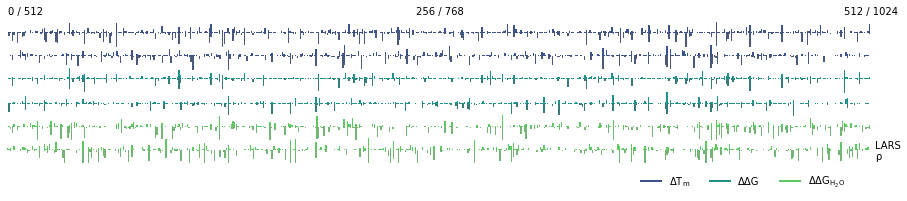

In [80]:
fig, axes = plt.subplots(6, 1, figsize=(12, 2))
cmap = sns.color_palette('viridis', 3)
cmap2 = sns.color_palette('viridis', 3, desat=.6)

for i, (co_cnt, sp_cnt) in enumerate(zip(delta_coefs.values(),
                                         delta_spears.values())):
    coefs = np.array([co_cnt[i] for i in range(1024)], dtype=float)
    spears = np.array([sp_cnt[i] for i in range(1024)], dtype=float)

    sps = scipy.stats.spearmanr(np.vstack((coefs, spears)).T, axis=0)[0]
    print(sps)


    def detick(ax):
        # ax.set_axis_off()
        # ax.set(yticks=[], xticks=[0, 256, 512, 768, 1024])
        # ax.text(0, .8, data.tex_lookup[delta_labels[i]], size=6, transform=ax.transAxes)
        ax.tick_params(length=0)
        ax.set(yticks=[], xticks=[], facecolor=(0, 0, 0, 0))


    ax = axes[2 * i]
    ax.bar(list(range(512)), coefs[:512], color=cmap[i], alpha=1)
    ax.bar(list(range(512)), -spears[:512], color=cmap2[i], alpha=1)
    ax.set_xlim(-1, 512)
    detick(ax)

    ax = axes[2 * i + 1]
    ax.bar(list(range(512, 1024)), coefs[512:], color=cmap[i], alpha=1)
    ax.bar(list(range(512, 1024)), -spears[512:], color=cmap2[i], alpha=1)
    ax.set_xlim(512, 1024)
    detick(ax)

axes[-1].yaxis.tick_right()
axes[-1].set(yticks=[-800, 800], yticklabels=['ρ', 'LARS'])
axes[0].set(xticks=[10, 256, 512], xticklabels=['0 / 512', '256 / 768', '512 / 1024'])
axes[0].xaxis.tick_top()

sns.despine(left=True, bottom=True)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=-.15)

# mess around with the legend
handles = list()
for de, co in zip(delta_labels, cmap):
    handles.append(mlines.Line2D([], [], color=co, label=data.tex_lookup[de], linewidth=2))
axes[-1].legend(title='', bbox_to_anchor=(.98, -.05), ncol=3, handles=handles,
                frameon=False, fancybox=False, facecolor=None)

save(fig, f'{wd.name}.png')
save(fig, f'feature_sampling.svg')
save(fig, f'feature_sampling.pdf')
